In [1]:
# !pip install transformers
# !pip install sentencepiece
# !pip install huggingface_hub
# !apt install libomp-dev
# !pip install faiss-gpu

In this work I will implement triplet loss approach for intent classification. Intent classification problem is very common in dialogue systems, because there can be a great amount of intet classes, each carrying its own system responce behaviour. 

Metric learning seems like a legit approach to this problem, because there can be numerous number of intent classes with imbalanced number of samples and we want to build such system, where we can fastly retrain our model with new samples. Also we would not want to overfit our model to a certain set of samples, instead we want to learn a metric which would be able to distinguish between different classes.


We can do it by learning a non linear function $F$ which will take an input vector $x \in R^m$, transform it in a new vector $x^* \in R^n$, where usually $n < m$. This function will transform vectors from $R^m$ in $R^n$ space in a such way that classes from one class will lie near each other and different classes will lie far away from each other. After this transformation we can use simple metric algorithms such as KNN in order to do classification.

We will be using triplet loss function with random sampling in order to learn desired fucntion capability.

This work is inspired by a Facebook paper - https://arxiv.org/abs/1503.03832


*As our base embeddings we will be using Hugging Face BERT-bert embeddings. The training will be conducted on GPU*

In [2]:
import numpy as np
from sklearn.metrics import classification_report
import torch
from torch import optim
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from transformers import BertModel, BertTokenizer
from transformers import AutoModel, AutoTokenizer

torch.manual_seed(42)
np.random.seed(42)

warnings.filterwarnings('ignore')

if torch.cuda.is_available():  
  dev = "cuda:1" 
else:  
  dev = "cpu"  
DEVICE = torch.device(dev)  
FROZEN_BERT = AutoModel.from_pretrained('bert-base-uncased').to(DEVICE)
TOKENIZER = AutoTokenizer.from_pretrained("bert-base-uncased")
MAX_LEN = 128

%load_ext autoreload
%autoreload 2

from src.utils.data import split_by_classes, validate_splits, load_dataframe
from src.utils.encoding import encode_data, create_tranformer_input
from src.utils.tsne import get_indexes_of_samples
from src.utils.triplets import TripletGenerator
from src.models.knn import KnnIndex
from src.models.metricbert import MetricBERT
from src.losses.losses import compute_triplet_loss, l2_distance, compute_silhouette_score

%matplotlib inline

/home/toomuch/anaconda3/envs/metric-learning/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-02-26 12:17:14.265470: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-26 12:17:14.996595: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-26 12:17:14.996657: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libn

The training, validation and test set I wiil be using OOS classification dataset. It contains 3 types of dataset - full, imbalanced and small datasets. Since I want to mimic the intent classification problem which occures a lot in dialogue systems - class imbalance, so I will be using imbalaced OOS dataset.
The paper for dataset - https://www.aclweb.org/anthology/D19-1131.pdf

In [3]:
# !git clone https://github.com/clinc/oos-eval.git

In [3]:
total_df = load_dataframe("./oos-eval/data/data_full.json")

print("Total size: ", total_df.shape)
total_df.head()

Total size:  (23700, 2)


,intents,targets
0,set a warning for when my bank account starts ...,oos
1,a show on broadway,oos
2,who has the best record in the nfl,oos
3,how do i find the area of a circle,oos
4,how many onions do i have on hand,oos


We will split files in following fashion - 60% classes to train, 20% to dev, 20% to test.

<Axes: >

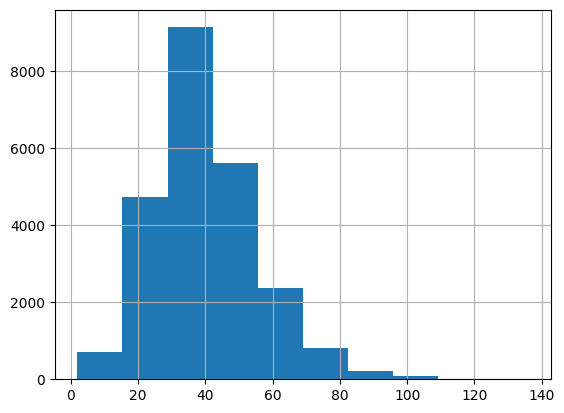

In [4]:
total_df['intents'].apply(lambda x: len(x)).hist()

In [5]:
splits = split_by_classes(total_df, train_classes_ratio=0.6, seed=42)

# Validate splits are correct
validate_splits(splits)

# Retrieve data
train_df = splits['train_df']
val_df = splits['val_df']
test_df = splits['test_df']
seen_test_df = splits['seen_test_df']
unseen_test_df = splits['unseen_test_df']

Here I will prepare data for input into BERT-base model. We will tokenize, pad it and mask padded symbols in order not to confuse BERT.

In [7]:
a = encode_data(
    text_samples=["hi, hi"],
    bert_encoder=FROZEN_BERT,
    tokenizer=TOKENIZER,
    device=DEVICE,
    max_length=MAX_LEN,
    batch_size=1,
    verbose=True
)
a

Encoding data: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


tensor([[-7.9588e-01, -2.4578e-01, -8.3082e-01,  6.7608e-01,  5.5406e-01,
         -5.7891e-02,  7.3652e-01,  1.6235e-01, -4.4965e-01, -9.9988e-01,
         -2.7525e-01,  8.6535e-01,  9.7135e-01,  4.4013e-01,  9.0157e-01,
         -5.3342e-01, -3.1664e-01, -4.1415e-01,  3.1627e-01, -1.2740e-01,
          4.9049e-01,  9.9991e-01,  1.6662e-01,  9.6635e-02,  3.7986e-01,
          9.7159e-01, -7.6144e-01,  9.0673e-01,  9.4718e-01,  5.5351e-01,
         -4.7194e-01, -3.4664e-02, -9.8909e-01, -1.1515e-01, -9.4033e-01,
         -9.8549e-01,  1.8738e-01, -6.7372e-01,  5.4439e-03,  2.2855e-01,
         -8.8937e-01,  1.0872e-01,  9.9984e-01,  9.9846e-02,  3.5894e-01,
         -1.4926e-01, -9.9999e-01,  1.3791e-01, -8.0076e-01,  7.4018e-01,
          7.9485e-01,  6.7085e-01,  2.9789e-02,  3.7836e-01,  2.8681e-01,
         -1.0542e-01, -1.7777e-01,  7.7549e-02, -1.1649e-01, -4.7824e-01,
         -4.7618e-01,  2.6904e-01, -8.4538e-01, -8.8193e-01,  8.0556e-01,
          7.1235e-01, -1.4072e-01, -1.

In [8]:
common_kwargs = {
    "bert_encoder": FROZEN_BERT,
    "tokenizer": TOKENIZER,
    "device": DEVICE,
    "max_length": MAX_LEN,
    "batch_size": 256,
    "verbose": True,
}

train_embeddings = encode_data(train_df["intents"].to_list(), **common_kwargs)
val_embeddings = encode_data(val_df["intents"].to_list(), **common_kwargs)
seen_test_embeddings = encode_data(seen_test_df["intents"].to_list(), **common_kwargs)
unseen_test_embeddings = encode_data(unseen_test_df["intents"].to_list(), **common_kwargs)

print(f"Train embeddings shape: {train_embeddings.shape}")
print(f"Val embeddings shape: {val_embeddings.shape}")
print(f"Seen test embeddings shape: {seen_test_embeddings.shape}")
print(f"Unseen test embeddings shape: {unseen_test_embeddings.shape}")

Encoding data: 57it [00:19,  2.95it/s]                        
Encoding data: 18it [00:05,  3.46it/s]                        
Encoding data: 10it [00:02,  4.31it/s]                      
Encoding data: 10it [00:02,  4.30it/s]                      

Train embeddings shape: torch.Size([14550, 768])
Val embeddings shape: torch.Size([4500, 768])
Seen test embeddings shape: torch.Size([2325, 768])
Unseen test embeddings shape: torch.Size([2325, 768])


Lets look at the embeddigns that we have in TSNE.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


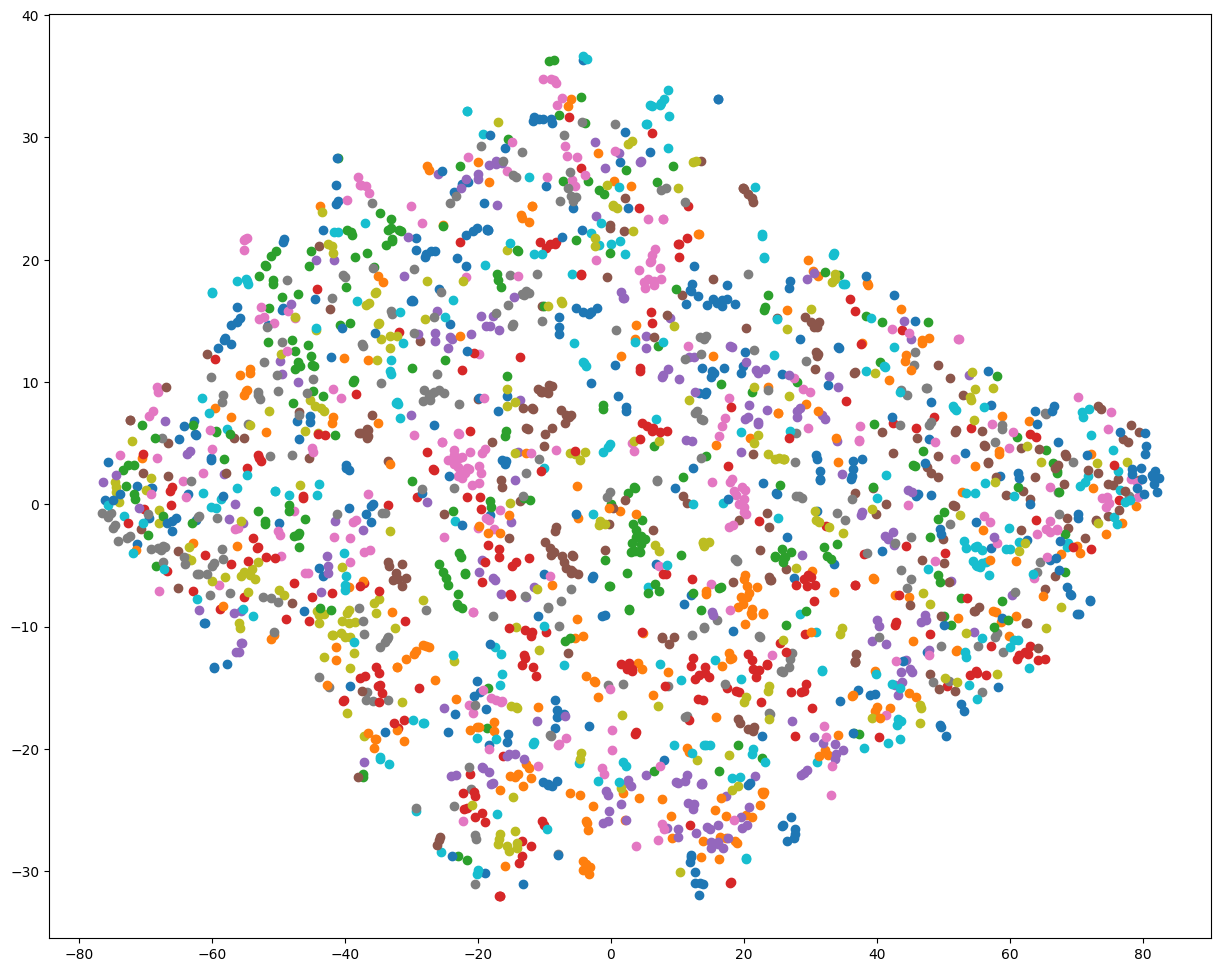

In [9]:
# %%time
tsne = TSNE()
tsne_original_val_emb = tsne.fit_transform(unseen_test_embeddings.detach().cpu())
val_classes_indexes = get_indexes_of_samples(unseen_test_df["targets"].values)

plt.figure(figsize=(15, 12))
for key, val in val_classes_indexes.items():
    plt.scatter(
        x=tsne_original_val_emb[val, 0], y=tsne_original_val_emb[val, 1], label=key
    )

### Baseline model



In [10]:
# Prepare embeddings to build KNN Space

storage_embeddings = np.concatenate(
    [
        train_embeddings.cpu().detach().numpy(),
        val_embeddings.cpu().detach().numpy(),
        seen_test_embeddings.cpu().detach().numpy(),
    ],
    axis=0,
)
classes_array = (
    train_df["targets"].to_list()
    + val_df["targets"].to_list()
    + seen_test_df["targets"].to_list()
)

print(f'storage embeddings shape: {storage_embeddings.shape}\nclasses length: {len(classes_array)}')

storage embeddings shape: (21375, 768)
classes length: 21375


In [12]:
# Let's test how KnnIndex works

knn_index = KnnIndex(storage_embeddings, classes_array)
vectorized_query = encode_data(["how old are you"], **common_kwargs).cpu().detach().numpy()
knn_index.search_index(vectorized_query)

Encoding data: 1it [00:00, 117.91it/s]


'how_old_are_you'

In [13]:
# Try to classify intents with KnnIndex on Bert embeddings

preds = []
test_intents = set(unseen_test_df["targets"].to_list())

vectorized_queries = (
    encode_data(unseen_test_df["intents"].to_list(), **common_kwargs)
    .cpu()
    .detach()
    .numpy()
)
for query in tqdm(vectorized_queries, desc="Predicting"):
    pred_class = knn_index.search_index(np.expand_dims(query, axis=0))
    if pred_class in test_intents:
        preds.append(pred_class)
    else:
        preds.append("misclassified")


print(classification_report(preds, unseen_test_df['targets'].tolist()))

Encoding data: 10it [00:02,  4.30it/s]                      
Predicting: 100%|██████████| 2325/2325 [00:35<00:00, 65.07it/s]

                         precision    recall  f1-score   support

        account_blocked       0.20      0.83      0.32        18
          are_you_a_bot       0.56      0.91      0.69        44
       change_user_name       0.51      1.00      0.67        33
    credit_limit_change       0.48      0.61      0.54        49
           damaged_card       0.23      0.69      0.35        26
                   date       0.51      0.79      0.62        42
               distance       0.20      0.73      0.32        22
              flip_coin       0.27      0.74      0.39        27
               fun_fact       0.28      0.65      0.39        37
   improve_credit_score       0.30      0.81      0.44        27
ingredient_substitution       0.45      0.95      0.61        39
       insurance_change       0.31      0.77      0.44        31
       last_maintenance       0.37      0.96      0.53        27
           lost_luggage       0.18      0.70      0.29        20
                  maybe 

### Metric learning approach

In order to sample easily, I will form dict of classes with samples indexes for each class.

In [14]:
train_target_indexes_dict = get_indexes_of_samples(train_df['targets'].to_list())

print('Train Target types: ', train_target_indexes_dict.keys())
print('Train Number of classes: ', len(train_target_indexes_dict.keys()))

Train Target types:  dict_keys(['balance', 'ingredients_list', 'replacement_card_duration', 'do_you_have_pets', 'tell_joke', 'exchange_rate', 'application_status', 'todo_list_update', 'roll_dice', 'flight_status', 'measurement_conversion', 'confirm_reservation', 'order_status', 'bill_due', 'plug_type', 'routing', 'cancel_reservation', 'rollover_401k', 'order_checks', 'change_ai_name', 'change_accent', 'meal_suggestion', 'meaning_of_life', 'calendar', 'make_call', 'w2', 'shopping_list_update', 'income', 'smart_home', 'translate', 'report_lost_card', 'vaccines', 'car_rental', 'no', 'expiration_date', 'tire_change', 'international_visa', 'shopping_list', 'change_volume', 'user_name', 'travel_notification', 'current_location', 'accept_reservations', 'calculator', 'sync_device', 'definition', 'meeting_schedule', 'directions', 'greeting', 'report_fraud', 'card_declined', 'interest_rate', 'repeat', 'play_music', 'order', 'international_fees', 'timezone', 'schedule_meeting', 'oil_change_how', 

In [15]:
val_target_indexes_dict = get_indexes_of_samples(val_df['targets'].to_list())

print('Val Target types: ', val_target_indexes_dict.keys())
print('Val Number of classes: ', len(val_target_indexes_dict.keys()))

Val Target types:  dict_keys(['payday', 'pay_bill', 'book_hotel', 'gas_type', 'text', 'weather', 'redeem_rewards', 'what_are_your_hobbies', 'freeze_account', 'how_busy', 'uber', 'min_payment', 'spending_history', 'transfer', 'restaurant_suggestion', 'recipe', 'who_do_you_work_for', 'taxes', 'where_are_you_from', 'who_made_you', 'tire_pressure', 'oil_change_when', 'find_phone', 'restaurant_reviews', 'food_last', 'apr', 'reminder', 'reset_settings', 'pin_change', 'rewards_balance'])
Val Number of classes:  30


In [16]:
tr_input_common_params = {
    "tokenizer": TOKENIZER,
    "device": DEVICE,
    "max_length": MAX_LEN,
}

train_token_ids_array, train_attention_mask_array = create_tranformer_input(
    train_df["intents"].to_list(), **tr_input_common_params
)
val_token_ids_array, val_attention_mask_array = create_tranformer_input(
    val_df["intents"].to_list(), **tr_input_common_params
)
train_token_ids_array.shape, val_token_ids_array.shape

(torch.Size([14550, 128]), torch.Size([4500, 128]))

The main key point in metric learning is sampling strategy. Here I will implement random sampling strategy. 

Random sampling strategy simply gets random sample from other classes excluding the anchor class.

In [18]:
train_triplet_generator = TripletGenerator(
    class2idx_dict=train_target_indexes_dict,
    token_ids_storage=train_token_ids_array,
    attention_storage=train_attention_mask_array,
)

example_batch = train_triplet_generator(n_triplets=2)
example_batch["anchor"]["token_ids"].shape, example_batch["negative"]["token_ids"].shape

(torch.Size([2, 128]), torch.Size([2, 128]))

In this work I am using custom loss function - triplet loss function. As a distance metric I will be using l2 distance.

In [22]:
a = torch.Tensor([[1, 1], [3, 4]]).to(DEVICE)
pos = torch.Tensor([[2, 3], [5, 6]]).to(DEVICE)
neg = torch.Tensor([[1, 1], [1, 2]]).to(DEVICE)

print("Triplet loss result:", compute_triplet_loss(a, pos, neg, l2_distance, device=DEVICE))

Triplet loss result: tensor([3.2361], device='cuda:1')


Here is presented the training of the dssm model for metric learning. As a validation metric I use recall - check if anchor to positive distance is less than anchor to negative for a given triplet.

I will be using l2 distance, because in current setting cos proved itself to be not so good.



In [23]:
torch.cuda.empty_cache()

In [24]:
# Additional Info when using cuda
if torch.device(DEVICE).type == "cuda":
    print(torch.cuda.get_device_name(0))
    print("Memory Usage:")
    print("Allocated:", round(torch.cuda.memory_allocated(0) / 1024**3, 1), "GB")
    print("Cached:   ", round(torch.cuda.memory_cached(0) / 1024**3, 1), "GB")

NVIDIA GeForce RTX 3090
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [25]:
compute_silhouette_score(
    encoder=FROZEN_BERT,
    number_of_classes=10,
    target_indexes_dict=train_target_indexes_dict,
    token_ids_array=train_token_ids_array,
    attention_mask_array=train_attention_mask_array,
)

100%|██████████| 10/10 [00:00<00:00, 40.72it/s]


-0.14104043

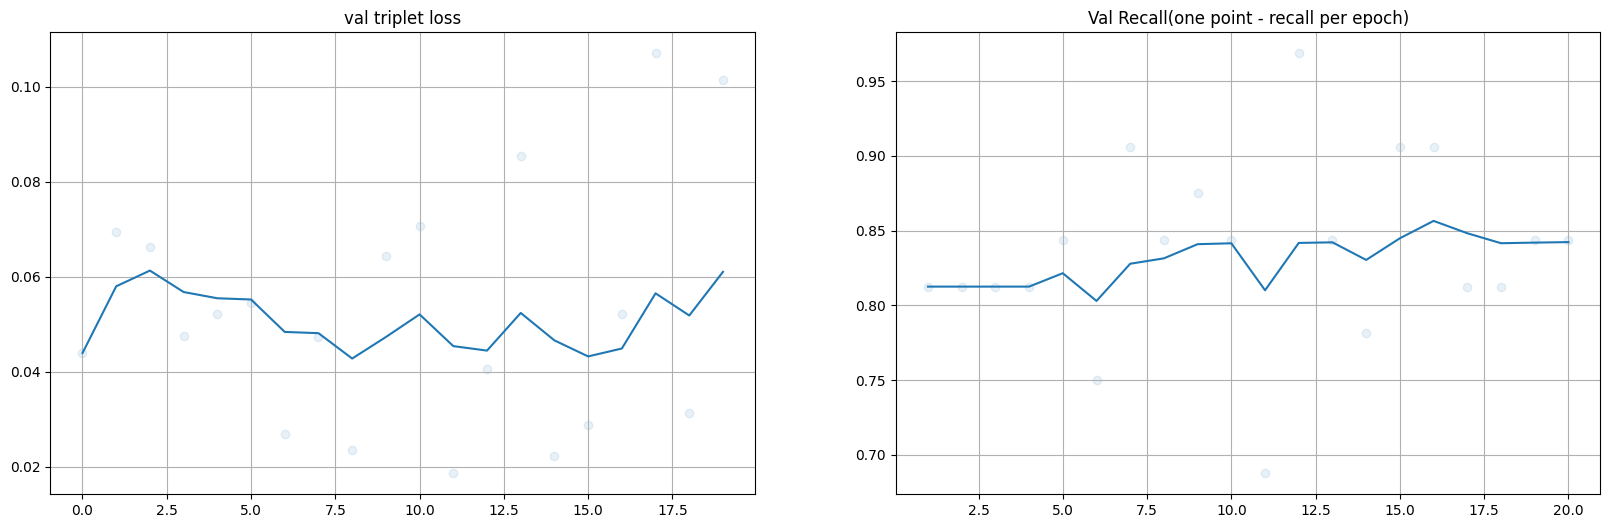

In [26]:
from src.loops.basic import fit


train_generator = TripletGenerator(
    train_target_indexes_dict,
    token_ids_storage=train_token_ids_array,
    attention_storage=train_attention_mask_array,
)

val_generator = TripletGenerator(
    val_target_indexes_dict,
    token_ids_storage=val_token_ids_array,
    attention_storage=val_attention_mask_array,
)

metric_bert = MetricBERT(FROZEN_BERT)
optimizer = optim.Adam(metric_bert.parameters(), lr=2e-5)


fit(
    dataset_passes=20,
    device=DEVICE,
    model=metric_bert,
    optimizer=optimizer,
    train_generator=train_generator,
    val_generator=val_generator,
    train_target_indexes_dict=train_target_indexes_dict,
    train_token_ids_array=train_token_ids_array,
    train_attention_mask_array=train_attention_mask_array,
)

In [27]:
encode_data(['hi'], FROZEN_BERT, tokenizer=TOKENIZER, device=DEVICE, max_length=MAX_LEN)[0][0]

Encoding data: 1it [00:00, 127.49it/s]


tensor(-0.7862, device='cuda:1')

In [28]:
encode_data(['hi'], metric_bert.bert, tokenizer=TOKENIZER, device=DEVICE, max_length=MAX_LEN)[0][0]

Encoding data: 1it [00:00, 131.25it/s]


tensor(-0.8084, device='cuda:1')

In [29]:
# Saving finetuned model

finetuned_bert_to_save = (
    metric_bert.bert.module if hasattr(metric_bert.bert, "module") else metric_bert.bert
)
finetuned_bert_to_save.save_pretrained("training_result/oos_finetuned_bert")

After we have seen that our loss moved to plateau, lets learn KNN classifier on top of the new learned embeddings.

In [30]:
new_common_kwargs = {
    "bert_encoder": metric_bert.bert,
    "tokenizer": TOKENIZER,
    "device": DEVICE,
    "max_length": MAX_LEN,
    "batch_size": 256,
    "verbose": True,
}

new_train_embeddings = encode_data(train_df["intents"].to_list(), **new_common_kwargs)
new_val_embeddings = encode_data(val_df["intents"].to_list(), **new_common_kwargs)
new_seen_test_embeddings = encode_data(
    seen_test_df["intents"].to_list(), **new_common_kwargs
)
new_unseen_test_embeddings = encode_data(
    unseen_test_df["intents"].to_list(), **new_common_kwargs
)

print(f"New Train shape: {new_train_embeddings.shape}")
print(f"New Val shape: {new_val_embeddings.shape}")
print(f"New Seen test shape: {new_seen_test_embeddings.shape}")
print(f"New Unseen test shape: {new_unseen_test_embeddings.shape}")

Encoding data: 57it [00:19,  2.90it/s]                        
Encoding data: 18it [00:05,  3.39it/s]                        
Encoding data: 10it [00:02,  4.25it/s]                      
Encoding data: 10it [00:02,  4.24it/s]                      

New Train shape: torch.Size([14550, 768])
New Val shape: torch.Size([4500, 768])
New Seen test shape: torch.Size([2325, 768])
New Unseen test shape: torch.Size([2325, 768])


In [31]:
# Prepare new embeddings from finetuned model

new_storage_embeddings = np.concatenate(
    [
        new_train_embeddings.cpu().detach().numpy(),
        new_val_embeddings.cpu().detach().numpy(),
        new_seen_test_embeddings.cpu().detach().numpy(),
    ],
    axis=0,
)
classes_array = (
    train_df["targets"].to_list()
    + val_df["targets"].to_list()
    + seen_test_df["targets"].to_list()
)
new_storage_embeddings.shape, len(classes_array)

((21375, 768), 21375)

In [32]:
# Initialize KNN & sanity check it

knn_index = KnnIndex(new_storage_embeddings, classes_array)
vectorized_query = encode_data(["how old are you"], **new_common_kwargs).cpu().detach().numpy()
knn_index.search_index(vectorized_query)

Encoding data: 1it [00:00, 131.44it/s]


'how_old_are_you'

In [33]:
# Try to classify intents with KnnIndex on Bert embeddings

preds = []
test_intents = set(unseen_test_df["targets"].to_list())

vectorized_queries = (
    encode_data(unseen_test_df["intents"].to_list(), **new_common_kwargs)
    .cpu()
    .detach()
    .numpy()
)
for query in tqdm(vectorized_queries, desc="Predicting"):
    pred_class = knn_index.search_index(np.expand_dims(query, axis=0))
    if pred_class in test_intents:
        preds.append(pred_class)
    else:
        preds.append("misclassified")

print(classification_report(preds, unseen_test_df['targets'].tolist()))

Encoding data: 10it [00:02,  4.25it/s]                      
Predicting: 100%|██████████| 2325/2325 [00:35<00:00, 65.68it/s]

                         precision    recall  f1-score   support

        account_blocked       0.59      1.00      0.74        44
          are_you_a_bot       0.65      0.92      0.76        51
       change_user_name       0.62      0.91      0.73        44
    credit_limit_change       0.67      0.95      0.79        44
           damaged_card       0.37      0.85      0.52        34
                   date       0.68      0.98      0.80        45
               distance       0.47      0.82      0.60        45
              flip_coin       0.76      1.00      0.86        57
               fun_fact       0.39      0.82      0.53        40
   improve_credit_score       0.58      1.00      0.74        43
ingredient_substitution       0.56      0.98      0.71        47
       insurance_change       0.58      1.00      0.74        45
       last_maintenance       0.51      0.97      0.67        37
           lost_luggage       0.74      0.98      0.84        58
                  maybe 

In [34]:
old_encoded_test_data = encode_data(['Hi, my name is Oleg'], **common_kwargs)
new_encoded_test_data = encode_data(['Hi, my name is Oleg'], **new_common_kwargs)

print('frozen bert: ', old_encoded_test_data[0][:5])
print('finetuned bert: ', new_encoded_test_data[0][:5])

Encoding data: 1it [00:00, 120.92it/s]
Encoding data: 1it [00:00, 92.94it/s]

frozen bert:  tensor([-0.9013, -0.6201, -0.9820,  0.8580,  0.8900], device='cuda:1')
finetuned bert:  tensor([-0.8477, -0.5292, -0.9862,  0.8274,  0.7810], device='cuda:1')


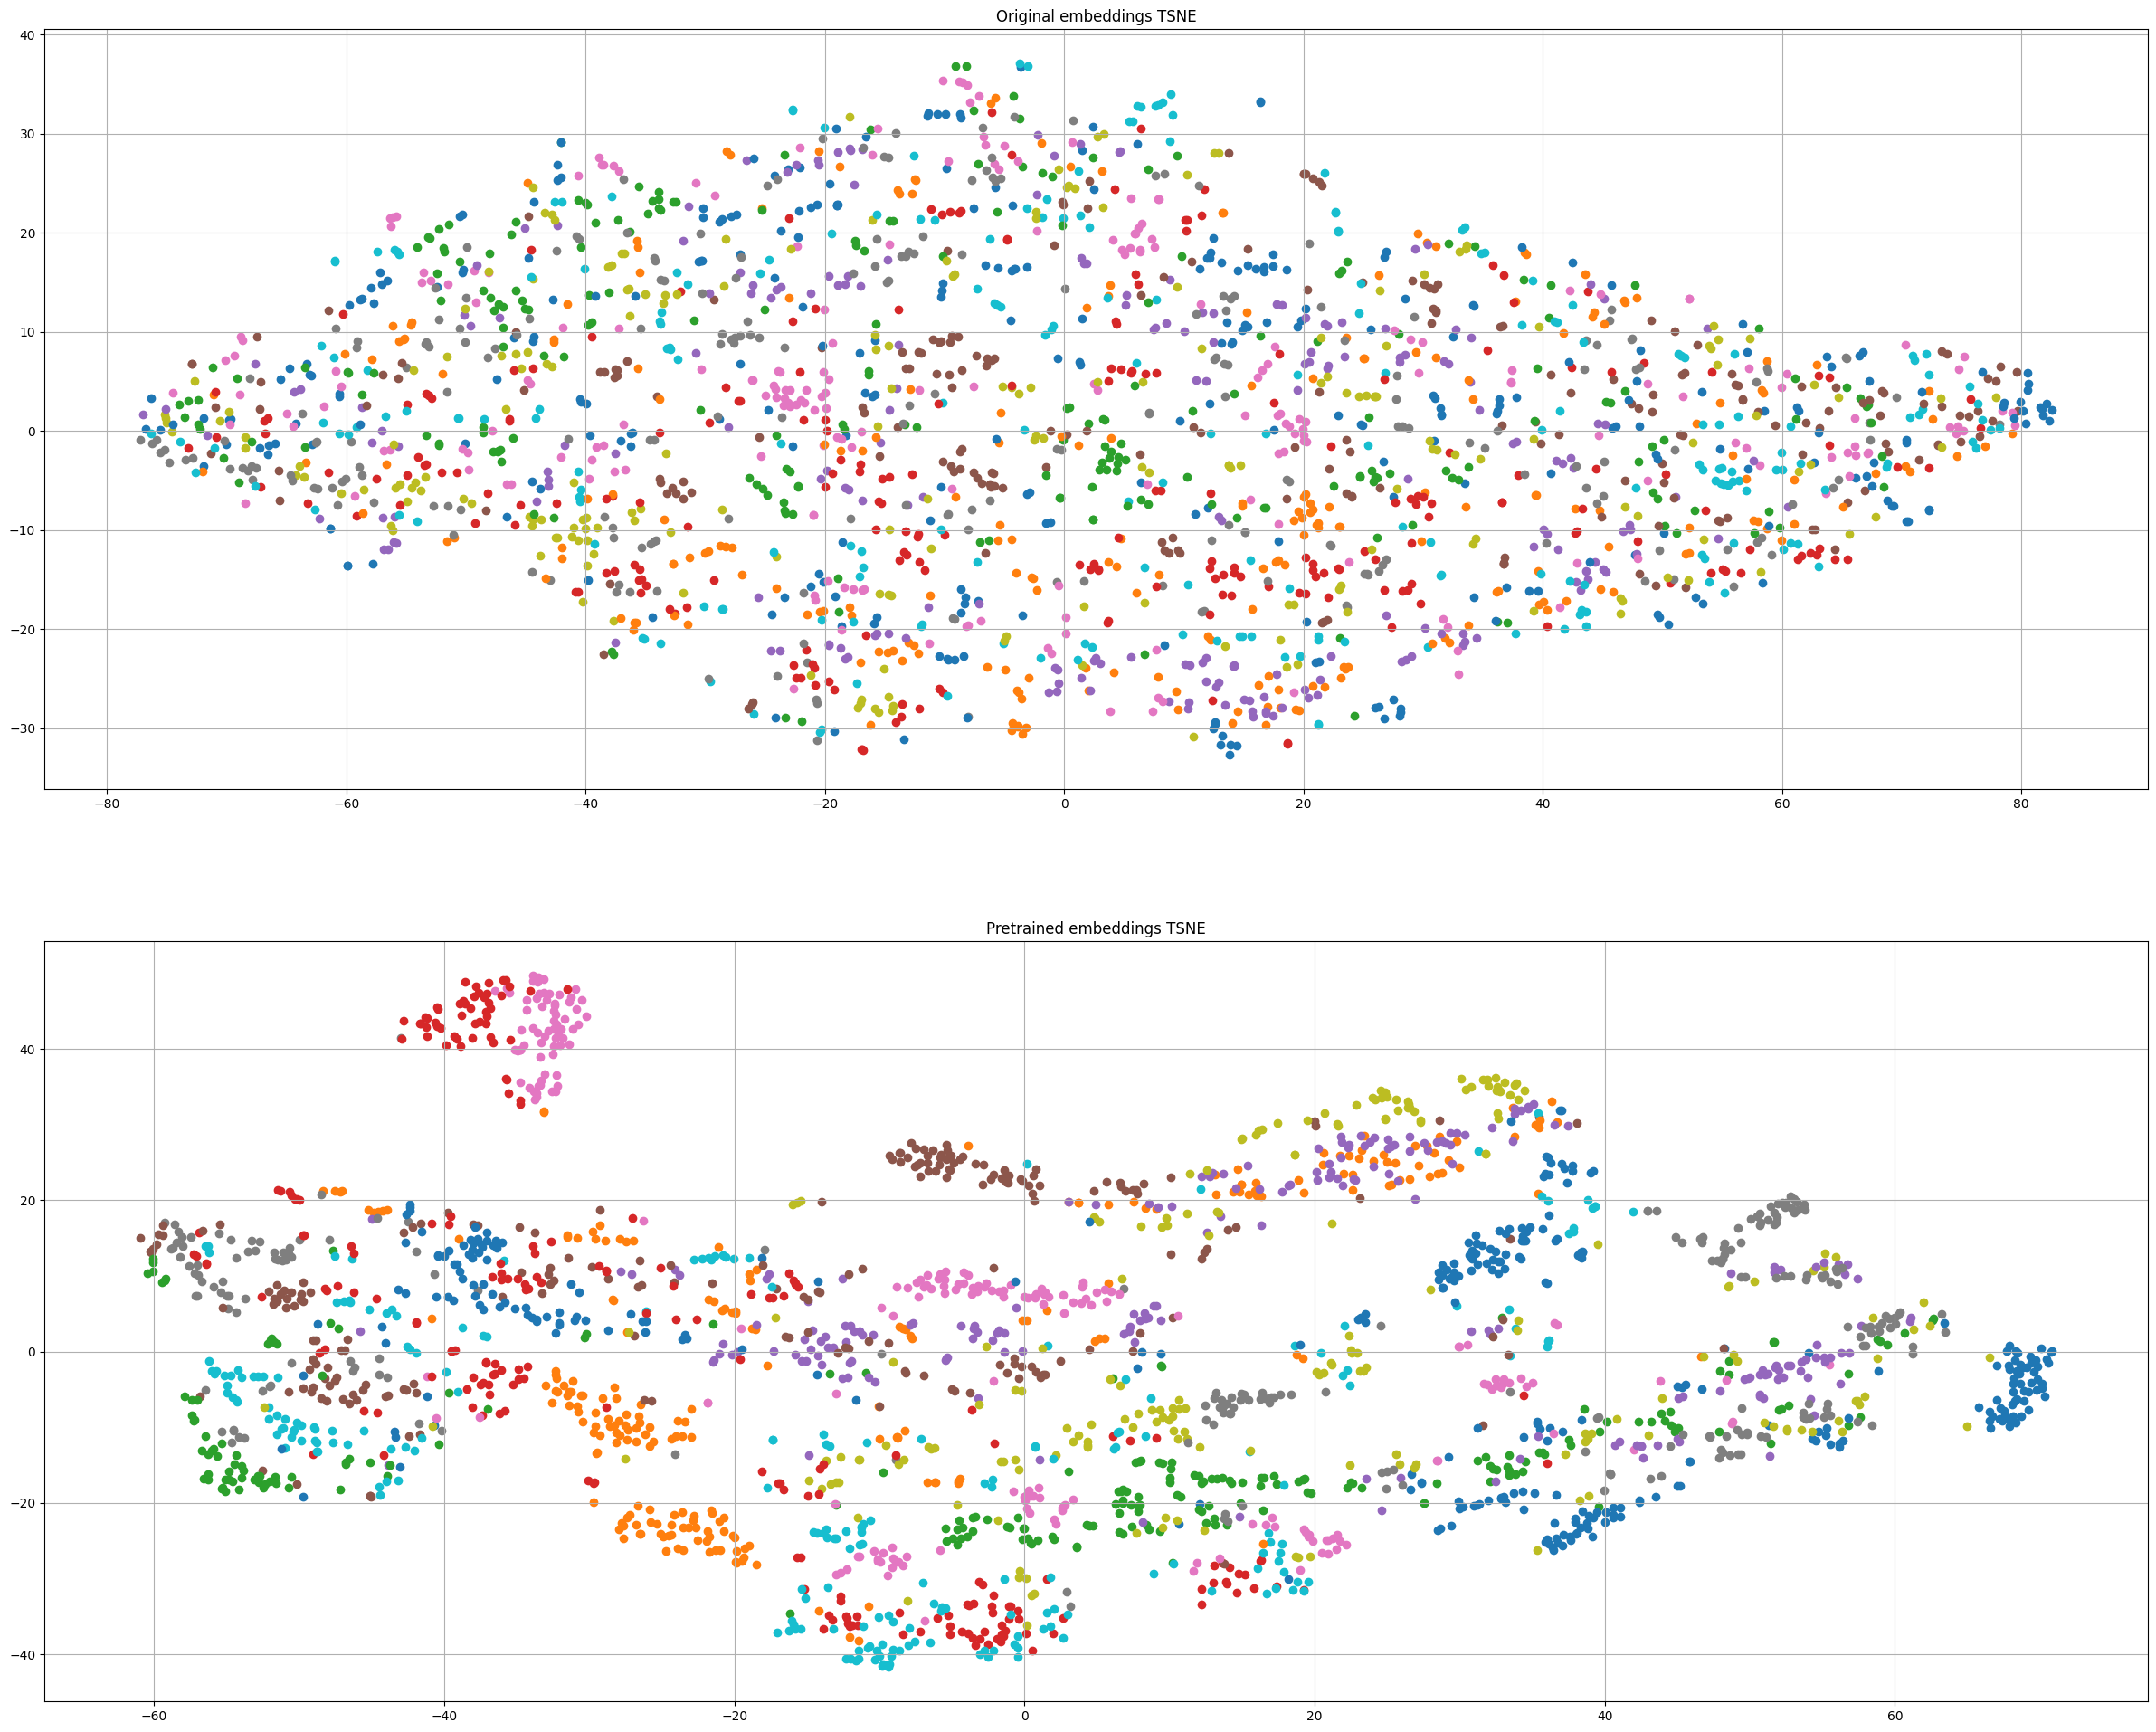

CPU times: user 1h 1min 53s, sys: 24.6 s, total: 1h 2min 18s
Wall time: 21.7 s


In [35]:
%%time
plt.figure(figsize=(30,24))

tsne = TSNE()
train_classes_indexes = get_indexes_of_samples(unseen_test_df['targets'].tolist())

tsne_original_bert_val_emb = tsne.fit_transform(unseen_test_embeddings.cpu())
tsne_pretrained_bert_val_emb = tsne.fit_transform(new_unseen_test_embeddings.cpu())


plt.subplot(2, 1, 1), plt.title('Original embeddings TSNE'), plt.grid()
for key, val in train_classes_indexes.items():
    plt.scatter(x=tsne_original_bert_val_emb[val,0],y=tsne_original_bert_val_emb[val,1],label=key)

plt.subplot(2, 1, 2), plt.title('Pretrained embeddings TSNE'), plt.grid()
for key, val in train_classes_indexes.items():
    plt.scatter(x=tsne_pretrained_bert_val_emb[val,0],y=tsne_pretrained_bert_val_emb[val,1],label=key)

plt.show()